In [4]:
from google.colab import files
from os import listdir
from numpy import asarray
from numpy import vstack
import matplotlib.pyplot as plt
import numpy as np
from google.colab import drive
# !mkdir -p saved_model
!pip install pyyaml h5py
import cv2
import os
import numpy as np

drive.mount('/content/drive')

!cp /content/drive/MyDrive/Colab\ Notebooks/Domain\ Adaptation/CycleGAN_def.py /content
!cp /content/drive/MyDrive/Colab\ Notebooks/Domain\ Adaptation/instancenormalization.py /content
from CycleGAN_def import *

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
#Load datasets

train_images = np.load('/content/drive/MyDrive/Colab Notebooks/GAPs/images.npy')
print ("Shape of dataset B (GAPSv2)", np.shape(train_images))

im_list = np.load("/content/drive/MyDrive/Colab Notebooks/CRACK500/crack500_train_patches.npy")
print ("Shape of dataset A (crack500)", np.shape(im_list))


Shape of dataset B (GAPSv2) (16758, 256, 256)
Shape of dataset A (crack500) (11376, 256, 256)


In [6]:
no_samples = 300
from sklearn.utils import resample
train_images_subset = resample(train_images,
                 replace=False,
                 n_samples=no_samples,
                 random_state=42)

from sklearn.utils import resample
im_list_subset = resample(im_list,
                 replace=False,
                 n_samples=no_samples,
                 random_state=42)

im_list_subset = np.expand_dims(im_list_subset, axis=3)
im_list_subset = np.repeat(im_list_subset, 3, axis=-1)
train_images_subset = np.expand_dims(train_images_subset, axis=3)
train_images_subset = np.repeat(train_images_subset, 3, axis=-1)

def preprocess_data(data): 	# scale from [0,255] to [-1,1]
	data = (np.array(data) - 127.5) / 127.5
	return data

train_images_subset_processed = preprocess_data(train_images_subset)
im_list_subset_processed = preprocess_data(im_list_subset)

print ("Domain B ----")
print (np.shape(train_images_subset))
print (np.min(train_images_subset), np.max(train_images_subset))
print (np.min(train_images_subset_processed), np.max(train_images_subset_processed))

print ("Domain A ----")
print (np.shape(im_list_subset))
print (np.min(im_list_subset), np.max(im_list_subset))
print (np.min(im_list_subset_processed), np.max(im_list_subset_processed))


Domain B ----
(300, 256, 256, 3)
8 255
-0.9372549019607843 1.0
Domain A ----
(300, 256, 256, 3)
0 255
-1.0 1.0


In [ ]:
# for direct results from modelA_to_B
im_list = np.expand_dims(im_list, axis=3)
im_list = np.repeat(im_list, 3, axis=-1)

def preprocess_data(data):
	data = (np.array(data) - 127.5) / 127.5
	return data

im_list_processed = preprocess_data(im_list)

CFD_translated = []
CFD_reconstructed = []
for i in range (len(im_list)):
  X = im_list_processed[np.array([i])]
  Y1  = model_AtoB.predict(X)
  Y2 = model_BtoA.predict(Y1)

  CFD_translated.append(Y1[0,:,:,0])
  CFD_reconstructed.append(Y2[0,:,:,0])

np.save("./drive/MyDrive/Colab Notebooks/CFD_Asphalt_pavement/translated_CFD.npy", CFD_translated)
np.save("./drive/MyDrive/Colab Notebooks/CFD_Asphalt_pavement/reconstructed_CFD.npy", CFD_reconstructed)

In [ ]:
from CycleGAN_def import *

dataset = [im_list_subset_processed,train_images_subset_processed]

# define input shape based on the loaded dataset
image_shape = dataset[0].shape[1:]
# generator: A -> B
g_model_AtoB = define_generator(image_shape)
# generator: B -> A
g_model_BtoA = define_generator(image_shape)
# discriminator: A -> [real/fake]
d_model_A = define_discriminator(image_shape)
# discriminator: B -> [real/fake]
d_model_B = define_discriminator(image_shape)
# composite: A -> B -> [real/fake, A]
c_model_AtoB = define_composite_model(g_model_AtoB, d_model_B, g_model_BtoA, image_shape)
# composite: B -> A -> [real/fake, B]
c_model_BtoA = define_composite_model(g_model_BtoA, d_model_A, g_model_AtoB, image_shape)

epochs= 25

# define properties of the training run
n_epochs, n_batch, = epochs, 1  #batch size fixed to 1 as suggested in the paper
# determine the output square shape of the discriminator
n_patch = d_model_A.output_shape[1]
# unpack dataset
trainA, trainB = dataset
# prepare image pool for fake images
poolA, poolB = list(), list()
# calculate the number of batches per training epoch
bat_per_epo = int(len(trainA) / n_batch)
# calculate the number of training iterations
n_steps = bat_per_epo * n_epochs

# manually enumerate epochs
for i in range(n_steps):
  X_realA, y_realA = generate_real_samples(trainA, n_batch, n_patch)
  X_realB, y_realB = generate_real_samples(trainB, n_batch, n_patch)
  X_fakeA, y_fakeA = generate_fake_samples(g_model_BtoA, X_realB, n_patch)
  X_fakeB, y_fakeB = generate_fake_samples(g_model_AtoB, X_realA, n_patch)
  X_fakeA = update_image_pool(poolA, X_fakeA)
  X_fakeB = update_image_pool(poolB, X_fakeB)
  g_loss2, _, _, _, _  = c_model_BtoA.train_on_batch([X_realB, X_realA], [y_realA, X_realA, X_realB, X_realA])
  dA_loss1 = d_model_A.train_on_batch(X_realA, y_realA)
  dA_loss2 = d_model_A.train_on_batch(X_fakeA, y_fakeA)
  g_loss1, _, _, _, _ = c_model_AtoB.train_on_batch([X_realA, X_realB], [y_realB, X_realB, X_realA, X_realB])
  dB_loss1 = d_model_B.train_on_batch(X_realB, y_realB)
  dB_loss2 = d_model_B.train_on_batch(X_fakeB, y_fakeB)
  print('Iteration>%d, dA[%.3f,%.3f] dB[%.3f,%.3f] g[%.3f,%.3f]' % (i+1, dA_loss1,dA_loss2, dB_loss1,dB_loss2, g_loss1,g_loss2))

  if (i+1) % (n_steps/2) == 0:
    filename1 = './drive/MyDrive/Colab Notebooks/Domain Adaptation/Saved_modelsGAN/'+str(no_samples)+'crack500_model_AtoB_%06d.h5' % (i+1)
    g_model_AtoB.save(filename1)

    filename2 = './drive/MyDrive/Colab Notebooks/Domain Adaptation/Saved_modelsGAN/'+str(no_samples)+'crack500_model_BtoA_%06d.h5' % (i+1)
    g_model_BtoA.save(filename2)

    # wts_AtoB = g_model_AtoB.get_weights()
    # wts_BtoA = g_model_BtoA.get_weights()
    # fn1 = './drive/MyDrive/Colab Notebooks/Domain Adaptation/Saved_wtsGAN/g_model_AtoB_%06d.npy' % (i+1)
    # fn2 = './drive/MyDrive/Colab Notebooks/Domain Adaptation/Saved_wtsGAN/g_model_BtoA_%06d.npy' % (i+1)
    # np.save(fn1, wts_AtoB)
    # np.save(fn2, wts_BtoA)

    #plot performance of model_AtoB
    n_samples=5
    X_in, _ = generate_real_samples(trainA, n_samples, 0)
    X_out, _ = generate_fake_samples(g_model_AtoB, X_in, 0)
    X_in = (X_in + 1) / 2.0
    X_out = (X_out + 1) / 2.0
    # plot real images
    for i in range(n_samples):
      pyplot.subplot(2, n_samples, 1 + i)
      pyplot.axis('off')
      pyplot.imshow(X_in[i])
    # plot real images
    for i in range(n_samples):
      pyplot.subplot(2, n_samples, 1 + n_samples + i)
      pyplot.axis('off')
      pyplot.imshow(X_out[i])
    FN1 = './drive/MyDrive/Colab Notebooks/Domain Adaptation/Saved_figGAN/'+str(no_samples)+'crack500_generated_plot_AtoB_%06d.jpeg' %  (i+1)
    pyplot.savefig(FN1)
    pyplot.close()

    #plot performance of model_BtoA
    X_in, _ = generate_real_samples(trainB, n_samples, 0)
    X_out, _ = generate_fake_samples(g_model_BtoA, X_in, 0)
    X_in = (X_in + 1) / 2.0
    X_out = (X_out + 1) / 2.0
    # plot real images
    for i in range(n_samples):
      pyplot.subplot(2, n_samples, 1 + i)
      pyplot.axis('off')
      pyplot.imshow(X_in[i])
    # plot translated image
    for i in range(n_samples):
      pyplot.subplot(2, n_samples, 1 + n_samples + i)
      pyplot.axis('off')
      pyplot.imshow(X_out[i])
    # save plot to file
    FN2 = './drive/MyDrive/Colab Notebooks/Domain Adaptation/Saved_figGAN/'+str(no_samples)+'crack500_generated_plot_BtoA_%06d.jpeg' %  (i+1)
    pyplot.savefig(FN2)
    pyplot.close()

/usr/local/lib/python3.10/dist-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values each

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 24ms/step
Iteration>2084, dA[0.008,0.011] dB[0.009,0.011] g[6.290,5.306]
1/1 [==============================] - 0s 21ms/step
Iteration>2085, dA[0.006,0.013] dB[0.109,0.054] g[4.784,5.331]
1/1 [==============================] - 0s 22ms/step
Iteration>2086, dA[0.014,0.004] dB[0.234,0.198] g[2.961,3.546]
1/1 [==============================] - 0s 154ms/step
Iteration>2087, dA[0.005,0.002] dB[0.010,0.057] g[2.357,3.177]
1/1 [==============================] - 0s 46ms/step
Iteration>2088, dA[0.007,0.002] dB[0.028,0.024] g[2.054,2.464]
1/1 [==============================] - 0s 29ms/step
Iteration>2089, dA[0.003,0.002] dB[0.069,0.009] g[3.358,4.580]
1/1 [==============================] - 0s 28ms/step
Iteration>2090, dA[0.007,0.002] dB[0.010,0.045] g[2.772,3.823]
1/1 [==============================] - 0s 181ms/step
Iteration>2091, dA[0.005,0.002] dB[0.151,0.279] g[4.441,4.684]
1/1 [======================

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Iteration>3750, dA[0.178,0.220] dB[0.047,0.132] g[2.315,2.531]


1/1 [==============================] - 0s 23ms/step
Iteration>3751, dA[0.224,0.068] dB[0.011,0.030] g[2.658,3.369]
1/1 [==============================] - 0s 22ms/step
Iteration>3752, dA[0.014,0.005] dB[0.008,0.013] g[3.351,3.186]
1/1 [==============================] - 0s 22ms/step
Iteration>3753, dA[0.088,0.459] dB[0.013,0.012] g[2.697,2.241]
1/1 [==============================] - 0s 329ms/step
Iteration>3754, dA[0.105,0.108] dB[0.035,0.027] g[18.904,15.169]
1/1 [==============================] - 0s 32ms/step
Iteration>3755, dA[0.177,0.010] dB[0.033,0.024] g[2.785,3.045]
1/1 [==============================] - 0s 22ms/step
Iteration>3756, dA[0.119,0.005] dB[0.013,0.009] g[1.918,2.525]
1/1 [==============================] - 0s 21ms/step
Iteration>3757, dA[0.017,0.181] dB[0.030,0.118] g[5.234,4.787]
1/1 [==============================] - 0s 22ms/step
Iteration>3758, dA[0.024,0.013] dB[0.033,0.029] g[4.111,4.024]
1/1 [==============================] - 0s 223ms/step
Iteration>3759, dA[0.080

In [ ]:
#Testing the model-----------------
from keras.models import load_model
from instancenormalization import InstanceNormalization
import numpy as np
from CycleGAN_def import *

cust = {'InstanceNormalization': InstanceNormalization}
model_AtoB = load_model('/content/drive/MyDrive/Colab Notebooks/Domain Adaptation/Saved_modelsGAN/200CFD_model_AtoB_005000.h5', cust)
model_BtoA = load_model('/content/drive/MyDrive/Colab Notebooks/Domain Adaptation/Saved_modelsGAN/200CFD_model_BtoA_005000.h5', cust)

# im_list_subset = np.expand_dims(im_list_subset, axis=3)
# im_list_subset = np.repeat(im_list_subset, 3, axis=-1)


/usr/local/lib/python3.10/dist-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


1/1 [==============================] - 0s 115ms/step


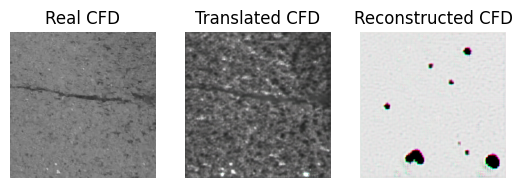

1/1 [==============================] - 0s 127ms/step


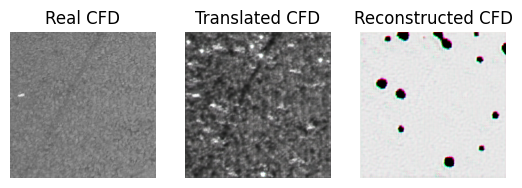

1/1 [==============================] - 0s 99ms/step


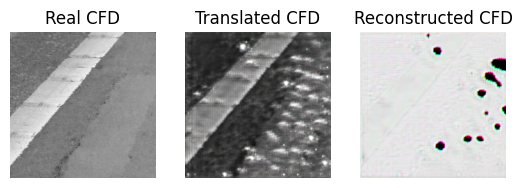

1/1 [==============================] - 0s 31ms/step


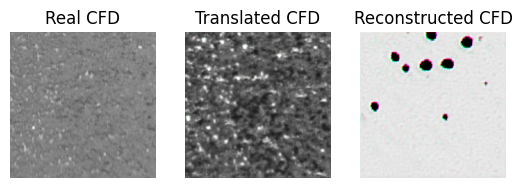

1/1 [==============================] - 0s 31ms/step


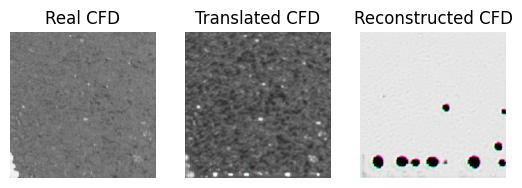

In [ ]:
# plot the image, its translation, and the reconstruction
def show_plot(imagesX, imagesY1, imagesY2):
	imagesX = (imagesX + 1) / 2.0
	imagesY1 = (imagesY1 + 1) / 2.0
	imagesY2 = (imagesY2 + 1) / 2.0
	images = vstack((imagesX, imagesY1, imagesY2))
	titles = ['Real CFD', 'Translated CFD', 'Reconstructed CFD']
	# plot images row by row
	for i in range(len(images)):
		# define subplot
		pyplot.subplot(1, len(images), 1 + i)
		# turn off axis
		pyplot.axis('off')
		# plot raw pixel data
		plt.imshow(images[i], vmin=0, vmax=255)
		# title
		pyplot.title(titles[i])
	pyplot.show()

# plot A->B->A (Monet to photo to Monet)
for i in range (5):
  ix = randint(0, im_list_processed.shape[0], 1)
  X = im_list_processed[ix]
  Y1  = model_AtoB.predict(X)
  Y2 = model_BtoA.predict(Y1)
  show_plot(X, Y1, Y2)

In [ ]:
import numpy as np
# im_list = np.load('/content/drive/MyDrive/Colab Notebooks/Domain Adaptation/PAVL_test_sample_DA_2.npy')
train_images = np.load('/content/drive/MyDrive/Colab Notebooks/images.npy')

print (np.shape(im_list))
print (np.shape(train_images))

In [ ]:
#creating two datasets of GAPs-10m and calculating wessertain distance between them
import numpy as np
train_images = np.load('/content/drive/MyDrive/Colab Notebooks/images.npy')
print (np.shape(train_images))

def select_sample(dataset, n_samples):
	# choose random instances
	ix = randint(0, dataset.shape[0], n_samples)
	# retrieve selected images
	X = dataset[ix]
	return X

def wasserstein_distance(A, B):
  A_hist, _ = np.histogram(A, bins=255, range=(0,255), density=True)
  B_hist, _ = np.histogram(B, bins=255, range=(0,255), density=True)
  A_cdf = np.cumsum(A_hist)
  B_cdf = np.cumsum(B_hist)
  return np.abs(A_cdf - B_cdf).max()

from sklearn.utils import resample
sample_size_ls = [100, 200, 500, 1000, int(len(train_images)/2)]
for sample_size in sample_size_ls:
  train_images_subset1 = resample(train_images,
                  replace=False,
                  n_samples=sample_size,
                  random_state=42)
  train_images_subset2 = resample(train_images,
                  replace=False,
                  n_samples=sample_size,
                  random_state=42)
  print (np.shape(train_images_subset1), np.shape(train_images_subset2))

  print ("Sample size:", sample_size, "Distance:", wasserstein_distance(train_images_subset1, train_images_subset2))


(16758, 256, 256)
(100, 256, 256) (100, 256, 256)
Sample size: 100 Distance: 0.0
(200, 256, 256) (200, 256, 256)
Sample size: 200 Distance: 0.0
(500, 256, 256) (500, 256, 256)
Sample size: 500 Distance: 0.0
(1000, 256, 256) (1000, 256, 256)
Sample size: 1000 Distance: 0.0
(8379, 256, 256) (8379, 256, 256)
Sample size: 8379 Distance: 0.0


In [ ]:
# number of images in both dataset vs the wasserstein distance between the datasets

# im_list = np.load('/content/drive/MyDrive/Colab Notebooks/Domain Adaptation/PAVL_test_sample_DA_2.npy')
# train_images = np.load('/content/drive/MyDrive/Colab Notebooks/images.npy')

def select_sample(dataset, n_samples):
	# choose random instances
	ix = randint(0, dataset.shape[0], n_samples)
	# retrieve selected images
	X = dataset[ix]
	return X

# def wasserstein_distance(A, B):
#   A_hist, _ = np.histogram(A, bins=255, range=(0,255), density=True)
#   B_hist, _ = np.histogram(B, bins=255, range=(0,255), density=True)
#   A_cdf = np.cumsum(A_hist)
#   B_cdf = np.cumsum(B_hist)
#   return np.abs(A_cdf - B_cdf).max()

from sklearn.utils import resample
sample_size_ls = [500]
for sample_size in sample_size_ls:
  im_list_subset = resample(im_list,
                  replace=False,
                  n_samples=sample_size,
                  random_state=42)

  train_images_subset = resample(train_images,
                  replace=False,
                  n_samples=sample_size,
                  random_state=42)

  # im_list_subset = np.expand_dims(im_list_subset, axis=3)
  # im_list_subset = np.repeat(im_list_subset, 3, axis=-1)
  # im_list_subset = (np.array(im_list_subset) - 127.5) / 127.5
  print (np.shape(im_list_subset))
  print (np.shape(train_images_subset))

  results2 = []
  for i in range (sample_size):
    img = select_sample(np.array(im_list_subset), 1)
    img = np.expand_dims(img, axis=3)
    img = np.repeat(img, 3, axis=-1)
    img = (np.array(img) - 127.5) / 127.5
    pred = model_AtoB.predict(img)
    results2.append(pred)

  results2 = asarray(results2)
  results2 = results2[:,0,:,:,:]
  results2 = (results2 + 1) / 2.0
  results2 = results2*255
  print (np.shape(results2))

  A = im_list_subset
  B = train_images_subset
  wasserstein_distance_value = wasserstein_distance(A, B)
  print("Wasserstein distance between the two datasets:", wasserstein_distance_value)

  C = results2
  wasserstein_distance_value2 = wasserstein_distance(C, B)
  print("Wasserstein distance after transformation:", wasserstein_distance_value2)



In [ ]:
print (np.shape(im_list))
print (np.shape(train_images))
# print (len(im_list_subset))

(3100, 256, 256)
(16758, 256, 256)


In [ ]:
print (np.unique(results2))
np.save("./drive/MyDrive/Colab Notebooks/Domain Adaptation/results3_1000.npy", results2)
# results2 = np.load("./drive/MyDrive/Colab Notebooks/Domain Adaptation/results2_400.npy")

[0.01496229 0.01496235 0.01507181 ... 0.9999999  0.99999994 1.        ]


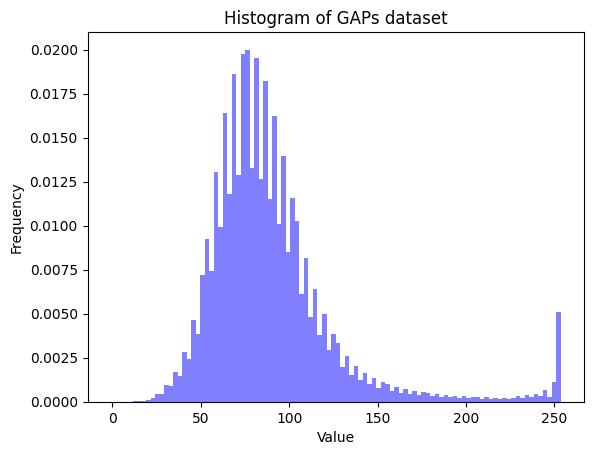

In [ ]:
import matplotlib.pyplot as plt

# im_list_subset = (im_list_subset*127.5)+ 127.5
# hist_a, bin_edges = np.histogram(im_list_subset, bins=100, range=(0,255), density=True)
# plt.bar(bin_edges[:-1], hist_a, width=bin_edges[1]-bin_edges[0], color='blue', alpha=0.5)
# plt.xlabel('Value')
# plt.ylabel('Frequency')
# plt.title('Histogram of PAVL images')
# plt.show()

# hist_a, bin_edges = np.histogram(results2*255, bins=100, range=(0,255), density=True)
# plt.bar(bin_edges[:-1], hist_a, width=bin_edges[1]-bin_edges[0], color='blue', alpha=0.5)
# plt.xlabel('Value')
# plt.ylabel('Frequency')
# plt.title('Histogram of transformed PAVL images')
# plt.show()

hist_a, bin_edges = np.histogram(train_images, bins=256, range=(0,255), density=True)
plt.bar(bin_edges[:-1], hist_a, width=bin_edges[1]-bin_edges[0], color='blue', alpha=0.5)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram of GAPs dataset')
plt.show()

In [ ]:
def select_sample(dataset, n_samples):
	# choose random instances
	ix = randint(0, dataset.shape[0], n_samples)
	# retrieve selected images
	X = dataset[ix]
	return X

# plot the image, its translation, and the reconstruction
def show_plot(imagesX, imagesY1, imagesY2):
	images = vstack((imagesX, imagesY1, imagesY2))
	titles = ['Real', 'Generated', 'Reconstructed']
	# scale from [-1,1] to [0,1]
	images = (images + 1) / 2.0
	# plot images row by row
	for i in range(len(images)):
		# define subplot
		pyplot.subplot(1, len(images), 1 + i)
		# turn off axis
		pyplot.axis('off')
		# plot raw pixel data
		pyplot.imshow(images[i])
		# title
		pyplot.title(titles[i])
	pyplot.show()

# im_list = np.load('/content/drive/MyDrive/Colab Notebooks/Domain Adaptation/PAVL_test_sample_DA_2.npy')
from sklearn.utils import resample
sample_size_ls = [500]
for sample_size in sample_size_ls:
  im_list_subset = resample(im_list,
                  replace=False,
                  n_samples=sample_size,
                  random_state=42)

# plot A->B->A (Monet to photo to Monet)
for i in range (len(im_list_subset)):
  A_real = select_sample(np.array(im_list_subset), 1)
  A_real = np.expand_dims(A_real, axis=3)
  A_real = np.repeat(A_real, 3, axis=-1)
  A_real = (np.array(A_real) - 127.5) / 127.5
  print("real", np.shape(A_real))
  B_generated  = model_AtoB.predict(A_real)
  print("generated",np.shape(B_generated))
  A_reconstructed = model_BtoA.predict(B_generated)
  print("reconstructed" ,np.shape(A_reconstructed))
  show_plot(A_real, B_generated, A_reconstructed)


Output hidden; open in https://colab.research.google.com to view.